In [126]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.layers import Dense, Activation
from keras import regularizers
from itertools import product
import tensorflow as tf
import keras as ke
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

ModuleNotFoundError: No module named 'cvxpy'

In [2]:
load_dir = "assets/car-rocket-ship/imnet_nofc/VGG19/128x128/"
X_train = np.load(load_dir + 'X_train.npy')
y_train = np.load(load_dir + 'y_train.npy')
X_test = np.load(load_dir + 'X_test.npy')
y_test = np.load(load_dir + 'y_test.npy')
N_tr = X_train.shape[0]
N_te = X_test.shape[0]
X_train = X_train.reshape(N_tr,-1)
X_test = X_test.reshape(N_te,-1)
in_size = X_train.shape[1]

In [24]:
reg=0.001
model_select = 2
if model_select is 0:
    model = Sequential([
        Dense(100,input_shape=(in_size,),kernel_regularizer=regularizers.l2(reg)),
        Activation('relu'),
        Dropout(0.3),
        Dense(50,kernel_regularizer=regularizers.l2(reg)),
        Activation('relu'),
        Dropout(0.3),
        Dense(3,kernel_regularizer=regularizers.l2(reg)),
        Activation('softmax')
        ])
if model_select is 1:
    model = Sequential([
        Dense(3,input_shape=(in_size,),kernel_regularizer=regularizers.l2(0.001)),
        Activation('softmax')
        ])

if model_select is 2:
    model = Sequential([
        #Dropout(0,input_shape=(in_size,)),
        Dense(10,input_shape=(in_size,),kernel_regularizer=regularizers.l2(0.5)),
        Activation('relu'),
        Dense(3,kernel_regularizer=regularizers.l2(reg)),
        Activation('softmax')
        ])

model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

Train on 600 samples, validate on 600 samples
Epoch 1/15
 - 4s - loss: 11.0731 - acc: 0.3333 - val_loss: 10.7526 - val_acc: 0.2550
Epoch 2/15
 - 0s - loss: 10.4726 - acc: 0.3017 - val_loss: 10.0419 - val_acc: 0.2883
Epoch 3/15
 - 0s - loss: 9.6653 - acc: 0.3500 - val_loss: 9.1663 - val_acc: 0.3600
Epoch 4/15
 - 0s - loss: 8.7809 - acc: 0.3933 - val_loss: 8.2918 - val_acc: 0.3967
Epoch 5/15
 - 0s - loss: 7.9135 - acc: 0.4483 - val_loss: 7.4642 - val_acc: 0.5433
Epoch 6/15
 - 0s - loss: 7.0810 - acc: 0.5250 - val_loss: 6.6627 - val_acc: 0.4667
Epoch 7/15
 - 0s - loss: 6.3333 - acc: 0.5250 - val_loss: 5.9721 - val_acc: 0.4717
Epoch 8/15
 - 0s - loss: 5.6592 - acc: 0.5750 - val_loss: 5.3521 - val_acc: 0.5000
Epoch 9/15
 - 0s - loss: 5.0706 - acc: 0.5883 - val_loss: 4.7874 - val_acc: 0.6350
Epoch 10/15
 - 0s - loss: 4.5420 - acc: 0.6700 - val_loss: 4.3039 - val_acc: 0.6783
Epoch 11/15
 - 0s - loss: 4.0751 - acc: 0.6833 - val_loss: 3.8787 - val_acc: 0.7883
Epoch 12/15
 - 0s - loss: 3.6745 - 

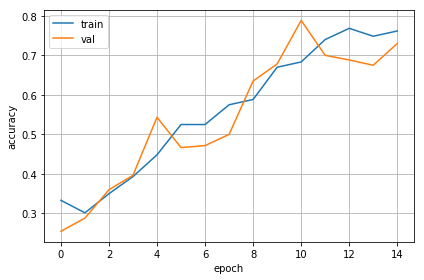

In [25]:
# Train the model and plot training info

hist = model.fit(X_train,y_train,
    validation_data=(X_test,y_test),
    batch_size = 100,
    epochs=15,
    verbose=2
    )
plt.plot(hist.history['acc'], label="train")
plt.plot(hist.history['val_acc'], label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [99]:
def weights_grad(X,model):
    N = X.shape[0]
    M = model.output.shape[1]
    w = model.trainable_weights
    out = model.layers[-2].output 
    grads = []
    for i in range(N): #iterate over the batch
        for j in range(M): #iterate over class score
            grads.append(k.gradients(out[i,j],w))
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    grads_evaled = sess.run(grads,feed_dict={model.input:X})
    # grads_evaled is is an M*N list of the gradients of the weights.
    # each element of this list in another list, that will be something like
    # [W1_grad, b1_grad, W2_grad, b2_grad ...]
    
    scores = sess.run(out,feed_dict={model.input:X})
    weights = sess.run(w,feed_dict={model.input:X})
    return grads_evaled, scores, weights

In [104]:
batch_size = 2
indices = np.random.choice(range(N_tr), batch_size, replace=True)
X_batch = X_train[indices]
print(X_batch.shape)
grads, scores, weights = weights_grad(X_batch,model)

(2, 8192)


/Users/theodiamandis/anaconda3/envs/cs231n/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [124]:
print(scores.shape)
print(len(weights))
print(weights[0].shape)

(2, 3)
4
(8192, 10)


In [123]:
## graident processing testing
num_params = len(grads[0])
num_classes = 3
# score_grads = [None]*num_classes
# for score_ind in range(num_classes):
#     score_grads[score_ind] = [np.zeros_like(grads[0][param]) for param in range(num_params)]

# # Sum gradidents across the batch
# for ii in range(batch_size):
#     for param_ind, class_ind in product(range(num_params),range(num_classes)) :
#         score_grads[class_ind][param_ind] += grads[3*ii + class_ind][param_ind]

# Make big weight vector for each of the scores
num_weights = in_size*10+10+10*3+3
for nn in range(batch_size):
    g = np.zeros((num_weights,3))
    for class_ind in range(num_classes):
        g[:,[class_ind]] = np.vstack([param.reshape(-1,1) for param in grads[3*nn + class_ind]])
#         for param_ind in range(num_params):
#             np.vstack((gc, grads[3*nn + class_ind][param_ind].reshape(-1,1)))
#          = gc
print(g.shape)

ytrain_inds = y_train.argmax(axis=1)
print(y_train[indices].shape)
print(true_class[indices].shape)
print(indices.shape)
print(y_train[0:10])
print(true_class[0:10])

wk = np.vstack([param.reshape(-1,1) for param in weights])
print(wk.shape)
print(len(weights))
print(weights[0].shape)

(81963, 3)
(2, 3)
(2,)
(2,)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
[2 0 2 0 0 2 1 2 2 0]
(81963, 1)
4
(8192, 10)


In [125]:
## Construct Optimization problem:
batch_size = 2
num_weights = in_size*10+10+10*3+3

indices = np.random.choice(range(N_tr), batch_size, replace=True)
X_batch = X_train[indices]
true_class = ytrain_inds[indices]
grads, scores, weights = weights_grad(X_batch,model)

y = scores.T
wk = np.vstack([param.reshape(-1,1) for param in weights])

w = cp.Variable(num_weights)
yhat = cp.Variable((num_classes,batch_size))
objective = cp.Minimize(cp.sum(-yhat[np.arange(N),true_class] + cp.log_sum_exp(yhat, axis=1)) + cp.norm(w,2))
for nn in range(batch_size):
    g = np.zeros((num_weights))
    for class_ind in range(num_classes):
        g[:,[class_ind]] = np.vstack([param.reshape(-1,1) for param in grads[3*nn + class_ind]])
    constraints += [yhat[:,nn] == y[:,nn] + g @ (w - wk)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()


/Users/theodiamandis/anaconda3/envs/cs231n/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


NameError: name 'cp' is not defined